## Chapter 20 Regression Machine Learning Case Study Project

In this chapter we will walk through a regression predictive modeling machine learning problem from end-to-end using Python. Specifically, the steps covered were:
- Problem Definition (Boston house price data).
- Loading the Dataset.
- Analyze Data (some skewed distributions and correlated attributes).
- Evaluate Algorithms (Linear Regression looked good).
- Evaluate Algorithms with Standardization (KNN looked good).
- Algorithm Tuning (K=3 for KNN was best).
- Ensemble Methods (Bagging and Boosting, Gradient Boosting looked good).
- Tuning Ensemble Methods (getting the most from Gradient Boosting).
Finalize Model (use all training data and confirm using validation dataset).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

#### 1. Problem Definition

For this project we will investigate the Boston House Price dataset. Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are defined as follows (taken from the UCI Machine Learning Repository):
- 1. CRIM: per capita crime rate by town
- 2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- 3. INDUS: proportion of non-retail business acres per town
- 4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- 5. NOX: nitric oxides concentration (parts per 10 million)
- 6. RM: average number of rooms per dwelling
- 7. AGE: proportion of owner-occupied units built prior to 1940
- 8. DIS: weighted distances to five Boston employment centers
- 9. RAD: index of accessibility to radial highways
- 10. TAX: full-value property-tax rate per \$10,000
- 11. PTRATIO: pupil-teacher ratio by town
- 12. B: 1000(Bk−0.63)^2 where Bk is the proportion of blacks by town
- 13. LSTAT: % lower status of the population
- 14. MEDV: Median value of owner-occupied homes in $1000s


#### 2. Load the Dataset

In [2]:
# load dataset
filename = 'data/Boston.csv'
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(filename, names=names)

#### 3. Analyze Data

In [3]:
# shape
df.shape

(506, 14)

In [4]:
# types
df.dtypes

,0
CRIM,float64
ZN,float64
INDUS,float64
CHAS,int64
NOX,float64
RM,float64
AGE,float64
DIS,float64
RAD,int64
TAX,int64


In [5]:
# head
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


We can confirm that the scales for the attributes are all over the place because of the diﬀering units. We may benefit from some transforms later on.

In [6]:
# descriptions
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


The min and max values as well are the means vary a lot. We are likely going to get better results by rescaling the data in some way.

In [7]:
# correlation
df.corr(method='pearson')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


This is interesting. We can see that many of the attributes have a strong correlation (e.g. > 0.70 or < -0.70).

#### 4. Data Visualizations

##### (1) Unimodal Data Visualizations

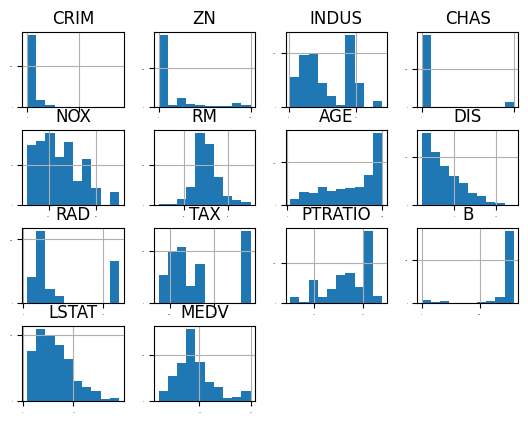

In [8]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

We can see that some attributes may have an exponential distribution, such as CRIM, ZN, AGE and B. We can see that others may have a bimodal distribution such as RAD and TAX.

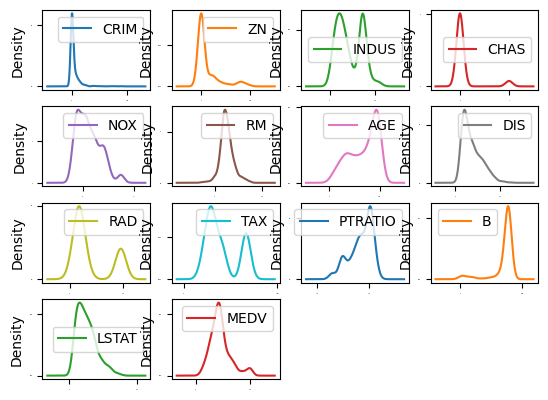

In [9]:
# density
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, sharey=False, fontsize=1)
plt.show()

This perhaps adds more evidence to our suspicion about possible exponential and bimodal distributions. It also looks like NOX, RM and LSTAT may be skewed Gaussian distributions, which might be helpful later with transforms.

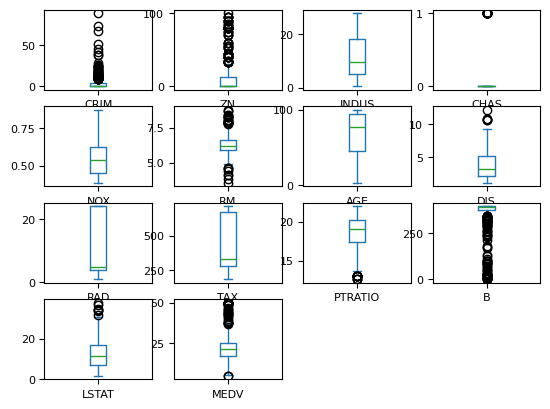

In [10]:
# box and whisker plots
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, fontsize=8)
plt.show()

This helps point out the skew in many distributions so much so that data looks like outliers (e.g. beyond the whisker of the plots).

##### (2) Multimodal Data Visualizations

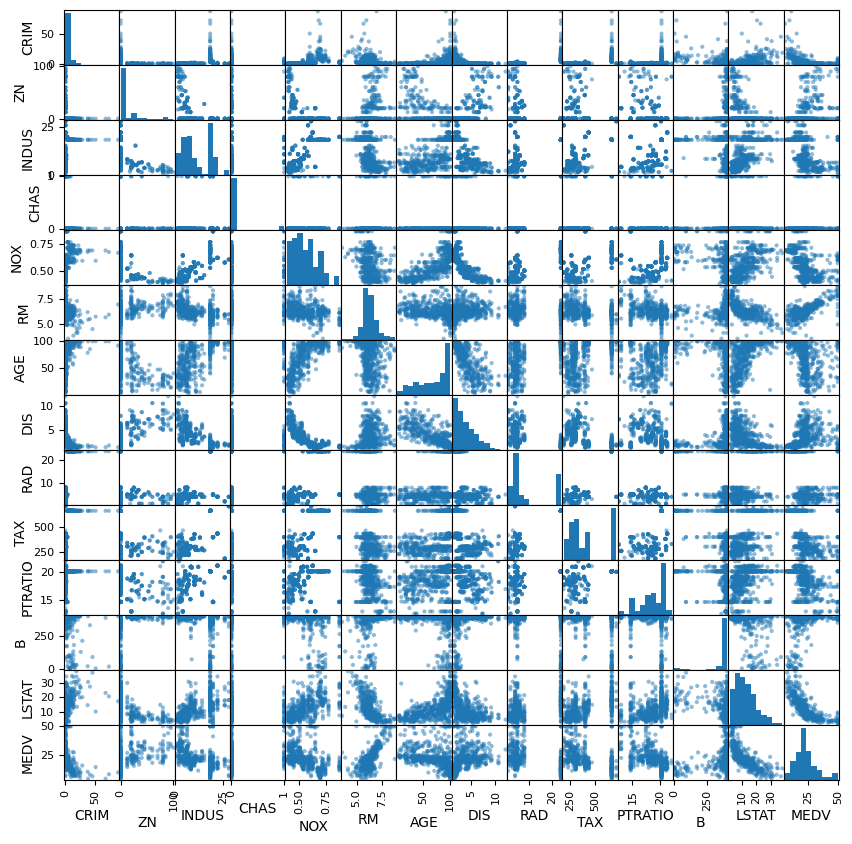

In [11]:
# scatter plot matrix
scatter_matrix(df, figsize=(10,10))
plt.show()

<Figure size 640x480 with 0 Axes>

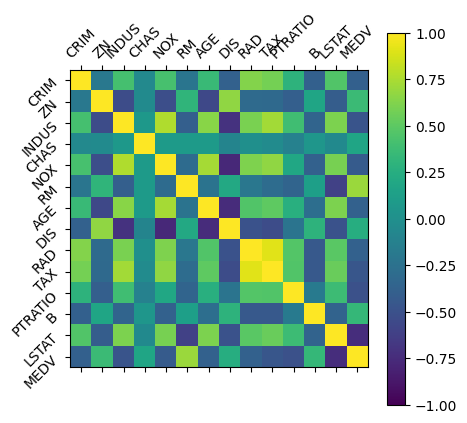

In [12]:
# correlation matrix
plt.figure()
plt.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none')
plt.colorbar()
plt.xticks(ticks=np.arange(0, 14, 1), labels=names, rotation=45)
plt.yticks(ticks=np.arange(0, 14, 1), labels=names, rotation=45)
plt.show()

There is a lot of structure in this dataset. We need to think about transforms that we could use later to better expose the structure which in turn may improve modeling accuracy. So far it would be worth trying:
- Feature selection and removing the most correlated attributes.
- Normalizing the dataset to reduce the eﬀect of diﬀering scales.
- Standardizing the dataset to reduce the eﬀects of diﬀering distributions.

#### 5. Validation Dataset

It is a good idea to use a validation hold-out set. This is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to confirm the accuracy of our final model. It is a smoke test that we can use to see if we messed up and to give us confidence on our estimates of accuracy on unseen data. We will use 80% of the dataset for modeling and hold back 20% for validation.

In [13]:
# split out validation dataset
array = df.values
X = array[:, :-1]
Y = array[:, -1]
validation_size = 0.20
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=7)

#### 6. Evaluate Algorithms: Baseline

In [14]:
# test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

In [15]:
# spot check algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# evaluate each model
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f'{name}, mean: {cv_results.mean()}, std: {cv_results.std()}')

LR, mean: -22.006008541988766, std: 12.188886010681346
LASSO, mean: -27.105803342288556, std: 13.165914704600763
EN, mean: -27.923013623389995, std: 13.156405425527131
KNN, mean: -39.808935902439025, std: 16.50796779686553
CART, mean: -27.01105, std: 19.133331517301755
SVR, mean: -67.82470522477362, std: 32.80153025353701


It looks like LR has the lowest MSE, followed closely by CART.

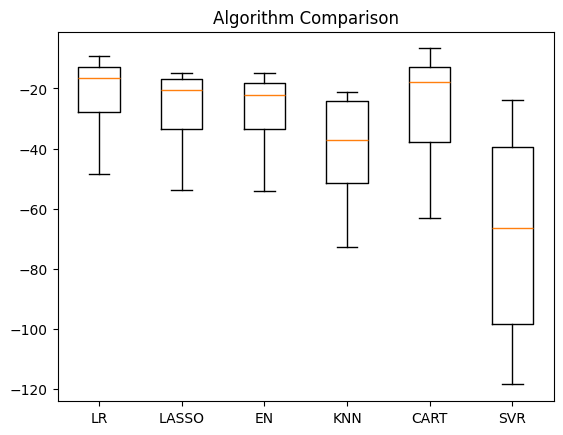

In [16]:
# compare algorithms
plt.boxplot(results, tick_labels=names)
plt.title('Algorithm Comparison')
plt.show()

#### 7. Evaluate Algorithms: Standardization

We suspect that the diﬀering scales of the raw data may be negatively impacting the skill of some of the algorithms. Let’s evaluate the same algorithms with a standardized copy of the dataset. This is where the data is transformed such that each attribute has a mean value of
zero and a standard deviation of 1. We also need to avoid data leakage when we transform the data. A good way to avoid leakage is to use pipelines that standardize the data and build the model for each fold in the cross validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [17]:
# standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()), ('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()), ('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()), ('SVR', SVR())])))

# evalute each model
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f'{name}, mean: {cv_results.mean()}, std: {cv_results.std()}')

ScaledLR, mean: -22.006008541988745, std: 12.188886010681157
ScaledLASSO, mean: -27.205895658130324, std: 12.124418229519785
ScaledEN, mean: -28.30115970360337, std: 13.609109541638533
ScaledKNN, mean: -21.45686665853659, std: 15.016217766474995
ScaledCART, mean: -25.38955487804878, std: 16.73913410028621
ScaledSVR, mean: -29.57043293858262, std: 18.05296397264449


We can see that scaling did have an eﬀect on KNN, driving the error lower than the other models.

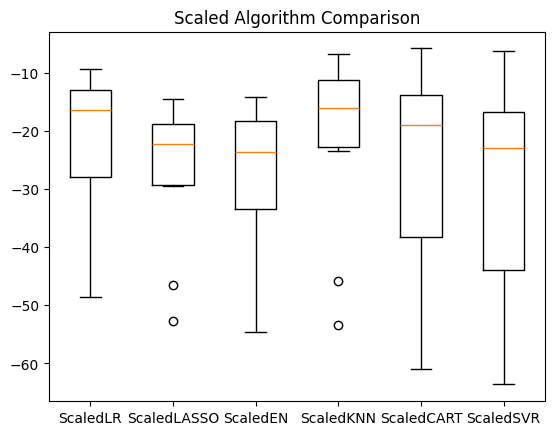

In [18]:
# compare algorithms
plt.boxplot(results, tick_labels=names)
plt.title('Scaled Algorithm Comparison')
plt.show()

#### 8. Improve Results with Tuning

We know from the results in the previous section that KNN achieves good results on a scaled version of the dataset. But can it do better. The default value for the number of neighbors in KNN is 7. We can use a grid search to try a set of diﬀerent numbers of neighbors and see if we can improve the score.

In [20]:
# KNN algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f'{mean}, {stdev}, {param}')

Best: -19.97798367208672 using {'n_neighbors': np.int64(3)}
-19.97798367208672, 13.803973471817649, {'n_neighbors': np.int64(3)}
-21.270966658536583, 14.833544154278053, {'n_neighbors': np.int64(5)}
-21.577291737182684, 14.952591857305263, {'n_neighbors': np.int64(7)}
-21.00107515055706, 14.70129720726499, {'n_neighbors': np.int64(9)}
-21.490306228582945, 14.86695742964106, {'n_neighbors': np.int64(11)}
-21.26853270313177, 14.454969000406491, {'n_neighbors': np.int64(13)}
-21.96809222222222, 14.209894040512225, {'n_neighbors': np.int64(15)}
-22.739879751455813, 14.492752185963981, {'n_neighbors': np.int64(17)}
-23.506900689142622, 14.903224416996835, {'n_neighbors': np.int64(19)}
-24.240302870416464, 15.156564920987337, {'n_neighbors': np.int64(21)}


You can see that the best for k (n neighbors) is 3 providing a mean squared error of -19.97798367208672.

#### 9. Ensemble Methods

Another way that we can improve the performance of algorithms on this problem is by using ensemble methods.
we will evaluate four diﬀerent ensemble machine learning
algorithms, two boosting and two bagging methods:
- Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
- Bagging Methods: Random Forests (RF) and Extra Trees (ET).

In [23]:
# ensembles
ensembles = []
ensembles.append(('ScaleAB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostRegressor())])))
ensembles.append(('ScaleGBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaleRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor())])))
ensembles.append(('ScaleET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  print(f'{name}, mean: {cv_results.mean()}, std: {cv_results.std()}')

ScaleAB, mean: -15.487033916888112, std: 7.781124053939494
ScaleGBM, mean: -10.99978433100969, std: 8.652905399478902
ScaleRF, mean: -12.881324512804872, std: 10.025527836575796
ScaleET, mean: -9.170173929999997, std: 6.358866046546408


We can see that we’re generally getting better scores than our linear and nonlinear algorithms in previous sections.

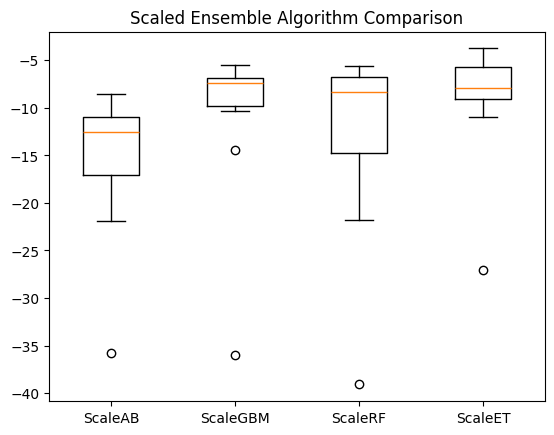

In [24]:
# compare algorithms
plt.figure()
plt.boxplot(results, tick_labels=names)
plt.title('Scaled Ensemble Algorithm Comparison')
plt.show()

#### 10. Tune Ensemble Methods

The default number of boosting stages to perform (n estimators) is 100. This is a good candidate parameter of Gradient Boosting to tune. Often, the larger the number of boosting stages, the better the performance but the longer the training time.

In [26]:
# tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50, 100, 150, 200, 250, 300, 350, 400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f'{mean}, {stdev}, {param}')

Best: -10.560637559010726 using {'n_estimators': np.int64(400)}
-11.629998657836461, 8.833221418068867, {'n_estimators': np.int64(50)}
-11.073455273415261, 8.772154692069284, {'n_estimators': np.int64(100)}
-10.838924199355183, 8.734377022610682, {'n_estimators': np.int64(150)}
-10.78556829456355, 8.657244115563072, {'n_estimators': np.int64(200)}
-10.65477776150534, 8.540551978773715, {'n_estimators': np.int64(250)}
-10.649385465510363, 8.497232113066538, {'n_estimators': np.int64(300)}
-10.589336898695533, 8.413596077609546, {'n_estimators': np.int64(350)}
-10.560637559010726, 8.353747488148537, {'n_estimators': np.int64(400)}


We can see that the best configuration was n estimators=400 resulting in a mean squared error of -10.560637559010726, better than the untuned method.

#### 11. Finalize Model

In this section we will finalize the gradient boosting model and evaluate it on our hold out validation dataset. First we need to prepare the model and train it on the entire training dataset.
This includes standardizing the training dataset before training.

In [28]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=400)
model.fit(rescaledX, Y_train)

GradientBoostingRegressor(n_estimators=400, random_state=7)

In [29]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(f'MSE: {mean_squared_error(Y_validation, predictions)}')

MSE: 11.902132586880027
